In [1]:
import cv2 as cv
import pysift
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load imaging dataset
### load imaging file names in each data dir

In [62]:
import glob
pos_train_file_name = glob.glob("/media/jasongong/Media/data/covid_train_test/train/positive/*")
neg_train_file_name= glob.glob("/media/jasongong/Media/data/covid_train_test/train/negative/*")

In [63]:
pos_test_file_name = glob.glob("/media/jasongong/Media/data/covid_train_test/test/positive/*")
neg_test_file_name= glob.glob("/media/jasongong/Media/data/covid_train_test/test/negative/*")

In [65]:
test_file_name = pos_test_file_name + neg_test_file_name

In [67]:
train_file_name = pos_train_file_name + neg_train_file_name

# Construct y
### 1 as positive and 0 as negative

In [66]:
y_tr_ones = np.ones(len(pos_train_file_name))
y_tr_zeros = np.zeros(len(neg_train_file_name))
y_tr = np.concatenate((y_tr_ones, y_tr_zeros))

In [64]:
y_te_ones = np.ones(len(pos_test_file_name))
y_te_zeros = np.zeros(len(neg_test_file_name))
y_te = np.concatenate((y_te_ones, y_te_zeros))

# Load image and apply sift feature alg
### use CV package
1. first read the imaging data by filename
2. then resize the image to 500 * 500 matrix
3. apply sift feature extraction alg
4. resulting output is an array of keypoint descriptors matrix for each image 
5. the descriptor matrix has number_features * 128 (description vector)

In [73]:
des_list = []
for i in range(len(train_file_name)):
    file = train_file_name[i]
    image = cv.imread(file, 0)
    image = cv.resize(image, (500, 500))
    
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    des_list.append(des)

# construct features vocabulary
### stack all features extracted from all images together into a grant feature matrix

In [74]:
des_total = np.vstack(des_list)

In [75]:
des_total.shape

(780855, 128)

# apply K-mean alg on features
### number of clusters to be 200

In [76]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=200, random_state=0).fit(des_total)

# construct X_tr
1. for each feature in each image, transform the specific features to K-mean clusters
2. count the number of each feature clusters
3. construct the bag of features matrix as X_tr, which has dimension: number of images * number of clusteres (200)
4. the resulting bag of features matrix, each entry encodes the frequencies of appearance of each feature clusters

In [77]:
label_total = []
for i in range(len(train_file_name)):
    des = des_list[i]
    label = kmeans.predict(des)
    label_total.append(label)

In [78]:
X_tr = np.zeros((len(train_file_name), 200))

for i in range(len(train_file_name)):
    label_list = label_total[i]
    for label in label_list:
        X_tr[i, label] += 1

In [80]:
X_tr

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 1., 1.],
       [1., 6., 1., ..., 1., 5., 2.],
       ...,
       [1., 0., 2., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 2., 1.],
       [0., 1., 2., ..., 0., 1., 2.]])

# Construct X_te
### using the same procedure above

In [81]:
des_test_list = []
for i in range(len(test_file_name)):
    file = test_file_name[i]
    image = cv.imread(file, 0)
    image = cv.resize(image, (500, 500))
    
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    des_test_list.append(des)

In [82]:
label_total_te = []
for i in range(len(test_file_name)):
    des = des_test_list[i]
    label = kmeans.predict(des)
    label_total_te.append(label)

In [83]:
X_te = np.zeros((len(test_file_name), 200))

In [84]:
for i in range(len(test_file_name)):
    label_list = label_total_te[i]
    for label in label_list:
        X_te[i, label] += 1

# SVM 
### use X_tr and y_tr
### C = 1

In [85]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)

In [86]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
clf.fit(X_tr, y_tr)

# plot ROC curve
### calculate accuracy and AUC metrics

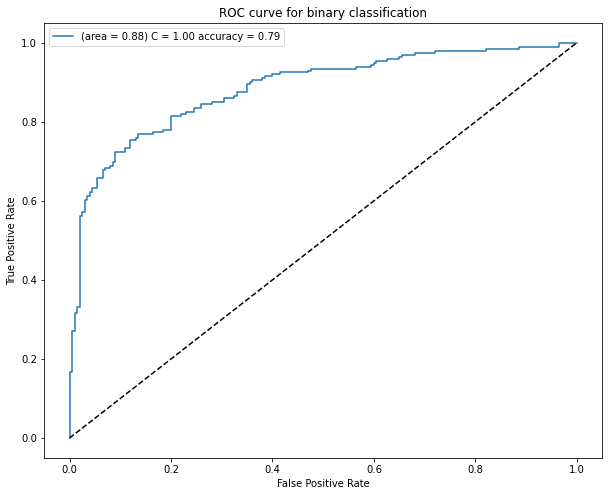

In [96]:
from sklearn.metrics import roc_curve, auc, accuracy_score
fig, ax = plt.subplots(figsize=(10,8))


y_predict = clf.predict(X_te)
y_score = clf.decision_function(X_te)
fpr, tpr, thresh = roc_curve(y_te, y_score)
roc_auc = auc(fpr, tpr)
Acura_score = accuracy_score(y_te, y_predict)
ax.plot(fpr, tpr, label='(area = %0.2f) C = %0.2f accuracy = %0.2f' % (roc_auc, clf.C, Acura_score))

ax.legend(loc="best")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title("ROC curve for binary classification")
ax.plot([0, 1], [0, 1], 'k--')

plt.show()

In [90]:
from sklearn.metrics import accuracy_score

In [91]:
accuracy_score(y_te, y_predict)

0.7919799498746867

# Confusion matrix of the SVM-sift-bag-of-feature model

<AxesSubplot:>

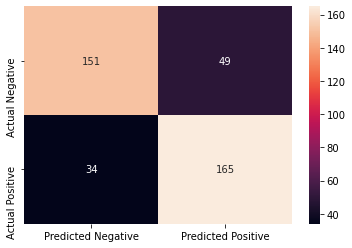

In [92]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_te, y_predict, labels=[0, 1]),index=["Actual Negative", "Actual Positive"],
columns=["Predicted Negative", "Predicted Positive"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

# Paramter Tuning

## Tuning k in K-mean alg
### determine how big is the model

In [103]:
Kmeans_k = []
for n_clust in np.linspace(50, 300, 6):
    kmeans_k = KMeans(n_clusters=int(n_clust), random_state=0).fit(des_total)
    Kmeans_k.append(kmeans_k)

In [108]:
models_k = []
for kmeans in Kmeans_k:
    
    label_total = []
    for i in range(len(train_file_name)):
        des = des_list[i]
        label = kmeans.predict(des)
        label_total.append(label)
    X_tr = np.zeros((len(train_file_name), kmeans.n_clusters))
    for i in range(len(train_file_name)):
        label_list = label_total[i]
        for label in label_list:
            X_tr[i, label] += 1
    
    clf = SVC(gamma='auto', probability=True, C = 1)
    clf.fit(X_tr, y_tr)
    
    models_k.append(clf)
    

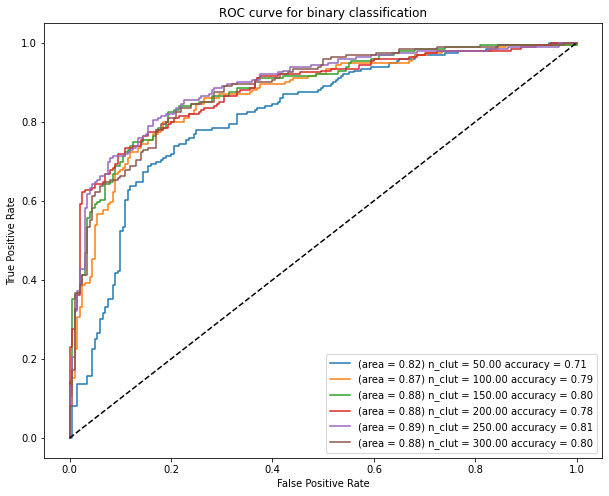

In [109]:
from sklearn.metrics import roc_curve, auc, accuracy_score
fig, ax = plt.subplots(figsize=(10,8))

for k in range(len(Kmeans_k)):
    clf = models_k[k]
    kmeans = Kmeans_k[k]
    
    n_K = np.linspace(50, 300, 6)
    n_clusters = int(n_K[k])
    
    label_total_te = []
    for i in range(len(test_file_name)):
        des = des_test_list[i]
        label = kmeans.predict(des)
        label_total_te.append(label)
    X_te = np.zeros((len(test_file_name), n_clusters))
    for i in range(len(test_file_name)):
        label_list = label_total_te[i]
        for label in label_list:
            X_te[i, label] += 1
    
    y_predict = clf.predict(X_te)
    y_score = clf.decision_function(X_te)
    fpr, tpr, thresh = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    Acura_score = accuracy_score(y_te, y_predict)
    ax.plot(fpr, tpr, label='(area = %0.2f) n_clut = %0.2f accuracy = %0.2f' % (roc_auc, n_clusters, Acura_score))

ax.legend(loc="best")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title("ROC curve for binary classification")
ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## tune paramter C in SVM

In [135]:
models_C = []
for c in np.linspace(0.01, 3, 10):
    print(c)
    clf = SVC(gamma='auto', probability=True, C = c)
    clf.fit(X_tr, y_tr)
    models_C.append(clf)

0.01
0.34222222222222226
0.6744444444444445
1.0066666666666668
1.338888888888889
1.6711111111111112
2.0033333333333334
2.3355555555555556
2.667777777777778
3.0


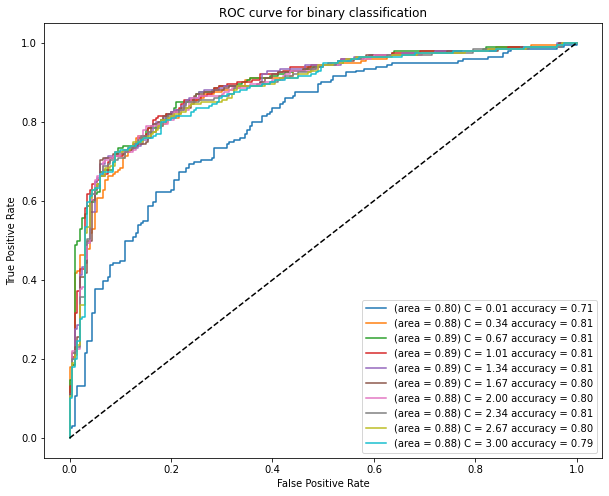

In [137]:
from sklearn.metrics import roc_curve, auc, accuracy_score
fig, ax = plt.subplots(figsize=(10,8))

for clf in models_C:
    y_predict = clf.predict(X_te)
    y_score = clf.decision_function(X_te)
    fpr, tpr, thresh = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    Acura_score = accuracy_score(y_te, y_predict)
    ax.plot(fpr, tpr, label='(area = %0.2f) C = %0.2f accuracy = %0.2f' % (roc_auc, clf.C, Acura_score))

ax.legend(loc="best")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title("ROC curve for binary classification")
ax.plot([0, 1], [0, 1], 'k--')

plt.show()

The result indicates that when C is at about 3.5 that is between 3 and 4, the model has the best performance as indicated by accuracy metrics. 

In [119]:
Kmeans_k[4].n_clusters

250

In [115]:
kmeans = Kmeans_k[4]

In [120]:
label_total = []
for i in range(len(train_file_name)):
    des = des_list[i]
    label = kmeans.predict(des)
    label_total.append(label)

In [121]:
X_tr = np.zeros((len(train_file_name), 250))

In [122]:
for i in range(len(train_file_name)):
    label_list = label_total[i]
    for label in label_list:
        X_tr[i, label] += 1

In [125]:
label_total_te = []
for i in range(len(test_file_name)):
    des = des_test_list[i]
    label = kmeans.predict(des)
    label_total_te.append(label)
X_te = np.zeros((len(test_file_name), 250))
for i in range(len(test_file_name)):
    label_list = label_total_te[i]
    for label in label_list:
        X_te[i, label] += 1

In [138]:
clf = SVC(gamma='auto', probability=True, C=1)

In [139]:
clf.fit(X_tr, y_tr)

SVC(C=1, gamma='auto', probability=True)

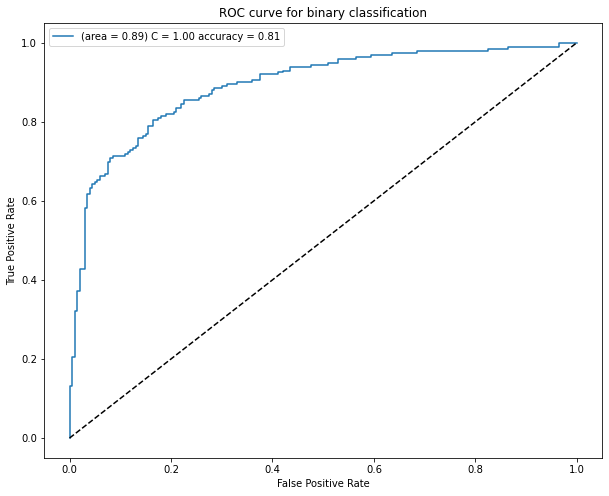

In [140]:
fig, ax = plt.subplots(figsize=(10,8))


y_predict = clf.predict(X_te)
y_score = clf.decision_function(X_te)
fpr, tpr, thresh = roc_curve(y_te, y_score)
roc_auc = auc(fpr, tpr)
Acura_score = accuracy_score(y_te, y_predict)
ax.plot(fpr, tpr, label='(area = %0.2f) C = %0.2f accuracy = %0.2f' % (roc_auc, clf.C, Acura_score))

ax.legend(loc="best")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title("ROC curve for binary classification")
ax.plot([0, 1], [0, 1], 'k--')

plt.show()

<AxesSubplot:>

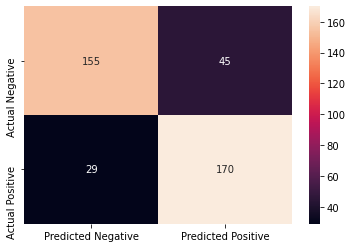

In [141]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_te, y_predict, labels=[0, 1]),index=["Actual Negative", "Actual Positive"],
columns=["Predicted Negative", "Predicted Positive"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")